In [1]:
# !pip install prophet
!pip install calendar

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
ERROR: Could not find a version that satisfies the requirement calendar (from versions: none)
ERROR: No matching distribution found for calendar


In [2]:
from __future__ import absolute_import, division, print_function, unicode_literals

import seaborn as sns

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import datetime as dt



import pandas as pd

from prophet import *
# from 

import pyarrow.parquet as pq


# from download import download

mpl.rcParams['figure.figsize'] = (24, 8)
mpl.rcParams['axes.grid'] = False


In [3]:
df = pd.read_csv('ad.csv')

In [4]:
col_list = [df.columns]
col_list

[Index(['name', 'datetime', 'temp', 'feelslike', 'dew', 'humidity', 'precip',
        'precipprob', 'preciptype', 'snow', 'snowdepth', 'windgust',
        'windspeed', 'winddir', 'sealevelpressure', 'cloudcover', 'visibility',
        'solarradiation', 'solarenergy', 'uvindex', 'severerisk', 'conditions',
        'icon', 'stations'],
       dtype='object')]

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 97176 entries, 0 to 97175
Data columns (total 24 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   name              97176 non-null  object 
 1   datetime          97176 non-null  object 
 2   temp              97176 non-null  float64
 3   feelslike         97176 non-null  float64
 4   dew               97176 non-null  float64
 5   humidity          97176 non-null  float64
 6   precip            97169 non-null  float64
 7   precipprob        97176 non-null  int64  
 8   preciptype        20134 non-null  object 
 9   snow              9257 non-null   float64
 10  snowdepth         9270 non-null   float64
 11  windgust          9270 non-null   float64
 12  windspeed         97176 non-null  float64
 13  winddir           97176 non-null  float64
 14  sealevelpressure  11419 non-null  float64
 15  cloudcover        97176 non-null  float64
 16  visibility        11418 non-null  float6

In [6]:
df['datetime'] =  pd.to_datetime(df['datetime'], format='%Y%m%d %H:%M:%S')

In [9]:
def drop_schema(df):
  drop_list = ['precip','windgust', 'windspeed', 'winddir', 'sealevelpressure', 'cloudcover' ,'visibility',
        'solarradiation', 'solarenergy', 'uvindex', 'severerisk', 'conditions',
        'icon', 'stations', 'name','feelslike', 'dew','precipprob', 'preciptype', 'snow', 'snowdepth']
  df = df.drop(drop_list , axis=1)
  return df


In [10]:
df = drop_schema(df)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 97176 entries, 0 to 97175
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   datetime  97176 non-null  datetime64[ns]
 1   temp      97176 non-null  float64       
 2   humidity  97176 non-null  float64       
dtypes: datetime64[ns](1), float64(2)
memory usage: 2.2 MB


In [11]:
df.head()

,datetime,temp,humidity
0,2012-01-01 00:00:00,22.7,85.27
1,2012-01-01 01:00:00,22.3,89.01
2,2012-01-01 02:00:00,21.7,93.47
3,2012-01-01 03:00:00,21.5,95.21
4,2012-01-01 04:00:00,21.5,95.21


In [12]:
T=(df['temp']*9/5)+32  
df['temp']=T
R=df['humidity']

hi = -42.379 + 2.04901523*T + 10.14333127*R - 0.22475541*T*R - 6.83783*(10**-3)*(T*T) - 5.481717*(10**-2)*R*R + 1.22874*(10**-3)*T*T*R + 8.5282*(10**-4)*T*R*R - 1.99*(10**-6)*T*T*R*R
df['heat_index'] = hi

In [13]:
df = df.drop(['temp','humidity'] , axis=1)

In [14]:
type(df)

pandas.core.frame.DataFrame

In [15]:
def resample_schema(df , period , type):
  df_id = df.set_index('datetime')
  if(type):
    df_id_sampled = df_id.resample(period).mean()
  else:
    df_id_sampled = df_id.resample(period).max()
  return df_id_sampled

In [16]:
df_id_d = resample_schema(df , 'D' , 1)

In [17]:
df_id_d.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4049 entries, 2012-01-01 to 2023-01-31
Freq: D
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   heat_index  4049 non-null   float64
dtypes: float64(1)
memory usage: 63.3 KB


In [18]:
df_id_d.head()

,heat_index
datetime,
2012-01-01,77.911019
2012-01-02,78.882806
2012-01-03,80.328880
2012-01-04,80.218994
2012-01-05,80.605878


In [19]:
#10 year span
df_id_d = df_id_d.loc[:'2022']

In [20]:
df_id_d.tail()

,heat_index
datetime,
2022-12-27,81.985540
2022-12-28,80.286642
2022-12-29,78.297665
2022-12-30,79.302377
2022-12-31,78.889770


In [22]:
def split(df , time_col ,split ,lower = None , upper = None):

  df['ds'] = df.index
  # - 
  df = df.rename({'heat_index' : 'y'}, axis = 'columns')
  split_dt = dt.datetime(split , 1 , 1 , 0 ,0)
  split_dt -= dt.timedelta(days=1)

  print("split at" , split_dt)
  if(lower == None):
    lower = df[time_col].iloc[0]
  if(upper == None):
    upper = df[time_col].iloc[-1]

  train = df[ (df[time_col] <= split_dt) ]
  test = df[(df[time_col] > split_dt) ]

  print(train.shape , test.shape)
  print(train.iloc[-1][time_col] , test.iloc[0][time_col])
  
  return train ,test

In [23]:
train, test = split(df_id_d , 'ds', 2021)

split at 2020-12-31 00:00:00
(3288, 2) (730, 2)
2020-12-31 00:00:00 2021-01-01 00:00:00


In [24]:
train

,y,ds
datetime,,
2012-01-01,77.911019,2012-01-01
2012-01-02,78.882806,2012-01-02
2012-01-03,80.328880,2012-01-03
2012-01-04,80.218994,2012-01-04
2012-01-05,80.605878,2012-01-05
...,...,...
2020-12-27,81.106715,2020-12-27
2020-12-28,78.131254,2020-12-28
2020-12-29,76.303892,2020-12-29


In [29]:
from sklearn.model_selection import train_test_split
def prophet_perp(df , pred_col):
  # - 
  df['ds'] = df.index
  # - 
  df = df.rename({pred_col : 'y'}, axis = 'columns')
  # - 
  train, test = train_test_split(df, test_size=0.2 , shuffle= False)

  # print(train.shape , test.shape)
  # print(train.iloc[-1][time_col] , test.iloc[0][time_col])
  
  return train , test
  

In [30]:
train , test = prophet_perp(df_id_d , 'heat_index')

In [31]:
train.tail(1)

,y,ds
datetime,,
2020-10-18,83.636243,2020-10-18


In [32]:
def prophet_train(train ):
  m = Prophet(
      
  )
  m.fit(train)
  print(m.params)
  return m


In [33]:
m = prophet_train(train)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpi95ixeo2/_o_i_u_g.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpi95ixeo2/s_sbdnlp.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=22684', 'data', 'file=/tmp/tmpi95ixeo2/_o_i_u_g.json', 'init=/tmp/tmpi95ixeo2/s_sbdnlp.json', 'output', 'file=/tmp/tmpi95ixeo2/prophet_modelok7c0bai/prophet_model-20230223182137.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:21:37 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:21:37 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


OrderedDict([('lp__', array([[9731.78]])), ('k', array([[-0.0260223]])), ('m', array([[0.812439]])), ('delta', array([[ 9.52717e-08,  5.37150e-04,  1.70702e-08, -2.52206e-01,
         1.92804e-07,  3.32614e-01,  3.99809e-01,  1.33075e-08,
        -4.14499e-01, -9.18585e-02,  3.05612e-07,  4.13843e-01,
        -9.33358e-02, -5.91867e-01,  4.31120e-08,  4.48661e-05,
         4.57080e-01,  1.53231e-08,  1.31495e-07, -1.37510e-01,
        -9.13055e-02,  1.70455e-07,  1.96928e-01,  6.95296e-08,
        -1.64477e-01]])), ('sigma_obs', array([[0.0286995]])), ('beta', array([[ 5.41695e-02, -5.64970e-02, -2.38287e-02, -6.87044e-03,
         1.36554e-02,  1.73787e-02, -4.54856e-03, -5.05476e-04,
        -2.16585e-03,  5.09071e-03,  3.92897e-04, -5.38149e-03,
        -3.29100e-03,  2.19035e-03,  2.91901e-03,  2.09626e-03,
        -8.00429e-04, -7.86990e-06,  1.25955e-03,  1.42706e-03,
         1.96751e-04,  4.97960e-04, -2.38735e-04, -4.34343e-04,
        -1.17891e-04, -2.69490e-05]])), ('trend',

In [34]:
future = m.make_future_dataframe(periods = 365)

In [35]:
forecast = m.predict(future)

In [36]:
forecast.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2012-01-01,83.141940,75.276779,82.592352,83.141940,83.141940,-4.285604,-4.285604,-4.285604,-0.056937,-0.056937,-0.056937,-4.228667,-4.228667,-4.228667,0.0,0.0,0.0,78.856336
1,2012-01-02,83.141111,75.453385,82.572275,83.141111,83.141111,-4.271087,-4.271087,-4.271087,-0.089088,-0.089088,-0.089088,-4.181999,-4.181999,-4.181999,0.0,0.0,0.0,78.870024
2,2012-01-03,83.140282,75.222724,82.757433,83.140282,83.140282,-4.159717,-4.159717,-4.159717,-0.012675,-0.012675,-0.012675,-4.147042,-4.147042,-4.147042,0.0,0.0,0.0,78.980565
3,2012-01-04,83.139453,75.245135,82.908944,83.139453,83.139453,-4.066515,-4.066515,-4.066515,0.057460,0.057460,0.057460,-4.123974,-4.123974,-4.123974,0.0,0.0,0.0,79.072939
4,2012-01-05,83.138625,75.472563,82.852201,83.138625,83.138625,-4.108975,-4.108975,-4.108975,0.003752,0.003752,0.003752,-4.112727,-4.112727,-4.112727,0.0,0.0,0.0,79.029650


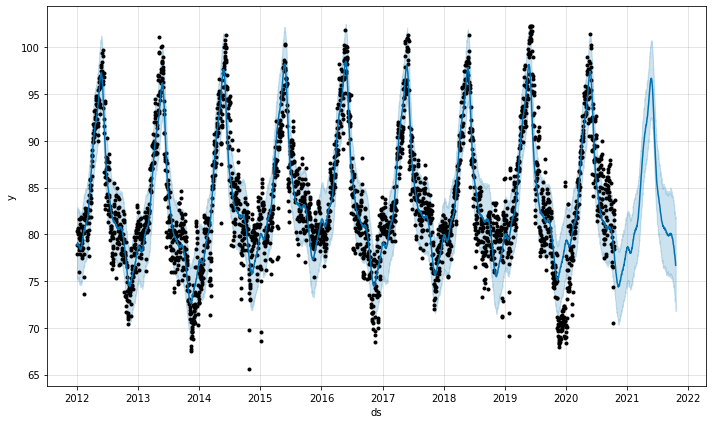

In [37]:
# fig = m.plot(forecast)
# bfig

In [38]:
# fig2 = m.plot_components(forecast)

In [39]:
# from prophet.plot import plot_yearly, plot_weekly
# fig3 = plot_yearly(m)

In [ ]:
from prophet.plot import *
plot_plotly(m, forecast)

In [ ]:
# Python
from prophet.serialize import model_to_json, model_from_json

with open('content/serialized_model.json', 'w') as fout:
    fout.write(model_to_json(m))  # Save model

In [40]:
# plot_components_plotly(m, forecast , uncertainty=True )

In [41]:
# plot_components_plotly(m, forecast , uncertainty=True , yearly_start= 1) 

In [42]:
# future.head(1)

In [43]:
# future_t = future.rename({'ds':'t'},axis = 'columns')

In [44]:
# trend = m.predict_trend(future_t)

In [ ]:
# fcst = forecast.set_index('ds')

In [45]:
# fcst.info()

In [46]:
# fcst[fcst.index > '2021-1-1']['trend'].plot()
# fcst[fcst.index > '2021-1-1']['trend_upper'].plot()
# fcst[fcst.index > '2021-1-1']['trend_lower'].plot()

In [47]:
# ax = test[test.ds < '2022-1-1']['y'].plot()
# ax = fcst[fcst.index > '2021-1-1']['yhat'].plot()
# ax = fcst[fcst.index > '2021-1-1']['yhat_lower'].plot()
# ax = fcst[fcst.index > '2021-1-1']['yhat_upper'].plot()

# ax.legend()

In [48]:
# pred =  pd.concat([df_id_d.set_index('ds')['temp'] ,forecast.set_index('ds')['yhat']] , axis=1) 

In [49]:
# pred.loc['2021' : '2021'].plot()

In [50]:
# from sklearn.metrics import mean_absolute_error 

In [51]:
# df_id_d.head(1)

In [52]:
# df_id_d['ds'] = df_id_d.index

In [53]:
# # import 
# year = 2021

# def get_month(fulldf , mi):

#     # mon_stat = calendra.monthrange(year, mi)
#     # mon_range = mon_stat[1]
#     mon_range = (dt.date(year, mi+1, 1) - dt.date(year, mi, 1)).days

#     mon_st = dt.datetime(year , mi , 1 ,0 ,0)
#     mon_end = dt.datetime(year , mi , mon_range , 0,0)
    
#     df_mon = fulldf[(fulldf['ds'] >= mon_st) & (fulldf['ds'] <= mon_end)]


#     return df_mon

In [54]:
# df_mon = get_month(df_id_d , 2)
# print(df_mon.head(1))
# print(df_mon.tail(1))
# print(df_mon.info())

In [56]:
# df_mon.info()

In [55]:


# def retain(fulldf):
#   mon_list = []

#   #--------- GET DF 
#   split = 2021
#   split_dt = dt.datetime(split , 1 , 1 , 0 ,0)
#   split_dt -= dt.timedelta(days=1)

#   fulldf = fulldf.rename({'temp' : 'y'}, axis = 'columns')
#   fulldf = fulldf.reset_index(drop = True)

#   basedf = fulldf[ (fulldf['ds'] <= split_dt)]
#   # basedf = basedf.reset_index(drop = True)

#   df_train = basedf
#   for mi in range(1 ,12):

#     # print(df_train.tail(1))
#     mon_pred = bbox(df_train)
#     mon_list.append(mon_pred)

#     #------------- UPDT
    
#     df_mon = get_month(fulldf , mi)
#     basedf = pd.concat([basedf , df_mon])

#     df_train = basedf

#   #----------- PLOT
#   return mon_list
#   # for mon in mon_list:
#   #   mon[mon.index > '2021-1-1']['trend'].plot()
#   #   mon[mon.index > '2021-1-1']['trend_upper'].plot()
#   #   mon[mon.index > '2021-1-1']['trend_lower'].plot()

In [57]:
# mon_list = retain(df_id_d)

In [58]:
# def bbox(df):]

# #- scale
#   # df[df] = df.index
#   # df_train = df.rename({'temp' : 'y'}, axis = 'columns')

#   #----------
#   m = Prophet()
#   m.fit(df)
#   print(m.params)
#   #----------

#   fmonth = m.make_future_dataframe(periods = 31)
  
#   mon_fcst = m.predict(fmonth)
#   print(mon_fcst.head(1))
#   print(mon_fcst.tail(1))
#   print(mon_fcst.shape)

#   # dim adj descale 
#   return mon_fcst  

In [59]:
# len(mon_list)

In [60]:
# mon_list[0].head()

In [61]:
# plotdf  = mon_list[0]
# plotdf = plotdf.set_index(plotdf['ds'])
# ax = plotdf[plotdf.index > '2021-1-1']['trend'].plot()
# ax = plotdf[plotdf.index > '2021-1-1']['trend_upper'].plot()
# ax = plotdf[plotdf.index > '2021-1-1']['trend_lower'].plot()
# ax.legend()

In [62]:
# for i in mon_list:
#   # print(i.head(1)['ds'])
#   print(i.tail(1)['ds'])
#   print('')

In [63]:
# ax = mon_list[0][mon_list[0][['ds']] > '2021-1-1']['trend_upper'].plot()
# ax = mon_list[0][mon_list[0][['ds']] > '2021-1-1']['trend'].plot()
# ax = mon_list[0][mon_list[0][['ds']] > '2021-1-1']['trend_lower'].plot()

In [64]:
# mon_list[0].plot()

In [65]:
# for mon in mon_list

In [66]:
# def plot_model_agg(pred_list):
  
#   for mon in pred_list:
#       ax = mon[mon[['ds']] > '2021-1-1']['trend_upper'].plot()
#       ax = mon[mon[['ds']] > '2021-1-1']['trend'].plot()
#       ax = mon[mon[['ds']] > '2021-1-1']['trend_lower'].plot()

In [67]:
# plot_model_agg(mon_list)

In [ ]:
helllo

In [ ]:
def train_model(city):
  CSV="{}.csv".format(city)
  df = pd.read_csv(CSV)
  df['datetime'] =  pd.to_datetime(df['datetime'], format='%Y%m%d %H:%M:%S')
  df = drop_schema(df)
  T=(df['temp']*9/5)+32  
  df['temp']=T
  R=df['humidity']
  hi = -42.379 + 2.04901523*T + 10.14333127*R - 0.22475541*T*R - 6.83783*(10**-3)*(T*T) - 5.481717*(10**-2)*R*R + 1.22874*(10**-3)*T*T*R + 8.5282*(10**-4)*T*R*R - 1.99*(10**-6)*T*T*R*R
  df['heat_index'] = hi
  df = df.drop(['temp','humidity'] , axis=1)
  df_id_d = resample_schema(df , 'D' , 1)
  df_id_d = df_id_d.loc[:'2022']
  train, test = split(df_id_d , 'ds', 2021)
  train , test = prophet_perp(df_id_d , 'heat_index')
  m = prophet_train(train)
  path="content/{city}_model.json".format(city)
  with open(path, 'w') as fout:
    fout.write(model_to_json(m))  # Save model
